In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
torch.cuda.is_available()

True

In [55]:
from google.colab import drive
drive.mount('/content/drive')
PATH_OF_DATA= '/content/drive/"My Drive"/IMG/qd'
!ls {PATH_OF_DATA}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Test  Train


## AlexNet

In [56]:
BS = 50
#torch.manual_seed(40)
transform = transforms.Compose([transforms.ToTensor(), 
                               transforms.Normalize([0.485, 0.456, 0.406],
                               [0.229, 0.224, 0.225])]) 
path_train = '/content/drive/My Drive/IMG/qd/Train'
path_test = '/content/drive/My Drive/IMG/qd/Test'

train_data = datasets.ImageFolder(root = path_train, transform = transform)
test_data = datasets.ImageFolder(path_test, transform = transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = BS, shuffle = True, pin_memory= True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size= BS,pin_memory= True)

class_names = train_data.classes
class_names

['Fall_Out', 'Good', 'White_Noise', 'transient']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


White_Noise Good transient Fall_Out transient Fall_Out Good Good transient Fall_Out
tensor([2, 1, 3, 0, 3, 0, 1, 1, 3, 0])


(-0.5, 3361.5, 1096.5, -0.5)

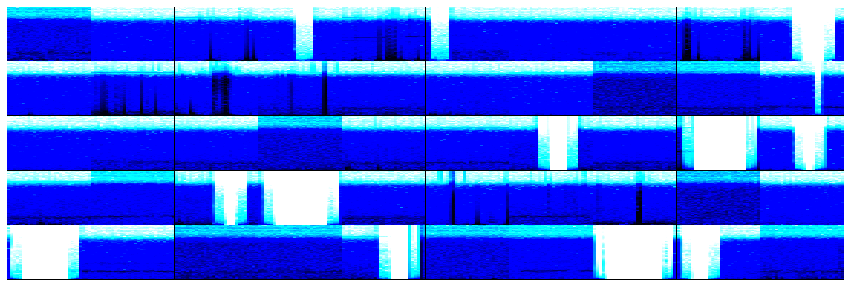

In [57]:
for images,labels in train_loader: 
    break

print(*np.array([class_names[i] for i in labels[0:10]]))  
print(labels[0:10])
im = make_grid(images, nrow=10) 
plt.figure(figsize=(15,18))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));
plt.axis('off')

In [58]:
class_names 

['Fall_Out', 'Good', 'White_Noise', 'transient']

In [59]:
AlexNetmodel = models.alexnet(pretrained=True)
AlexNetmodel 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
for param in AlexNetmodel.parameters():
    param.requires_grad = False

In [0]:
torch.manual_seed(42)
AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216, 2000),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(2000,200),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(200, len(class_names)), 
                                nn.LogSoftmax(dim=1))

AlexNetmodel = AlexNetmodel.cuda()

In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=1e-04)
for param in AlexNetmodel.parameters():
    print(param.requires_grad) 

False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True


In [63]:
epochs = 2

#max_trn_batch = 800
#max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):

        #if b == max_trn_batch:
            #break
        b+=1
        # forward prop
        y_pred = AlexNetmodel(X_train.cuda())
        loss = criterion(y_pred.cuda(), y_train.cuda())
        
        # count corr
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train.cuda()).sum()
        trn_corr += batch_corr
        
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss and acc
        if b%10 == 0 or b==1:
            print(f'epoch: {i+1:2} loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(BS*b):7.3f}%')
    train_losses.append(loss)
    train_correct.append(trn_corr)
    # eval test set
    with torch.no_grad():
      for b, (X_test, y_test) in enumerate(test_loader):
        #if b == max_tst_batch:
                #break
            # forward prop
        y_val = AlexNetmodel(X_test.cuda())

            # count corr test 
        predicted = torch.max(y_val.data, 1)[1] 
        tst_corr += (predicted == y_test.cuda()).sum()
    print('test done')
    loss = criterion(y_val.cuda(), y_test.cuda())
    test_losses.append(loss)
    test_correct.append(tst_corr)



epoch:  1 loss: 1.42817426  accuracy:  22.000%
epoch:  1 loss: 0.56550670  accuracy:  66.800%
epoch:  1 loss: 0.26987222  accuracy:  78.700%
epoch:  1 loss: 0.19494477  accuracy:  84.267%
epoch:  1 loss: 0.03955099  accuracy:  87.700%
epoch:  1 loss: 0.05956248  accuracy:  89.880%
epoch:  1 loss: 0.03287876  accuracy:  91.367%
epoch:  1 loss: 0.04858906  accuracy:  92.314%
epoch:  1 loss: 0.01781813  accuracy:  93.150%
epoch:  1 loss: 0.03807060  accuracy:  93.844%
epoch:  1 loss: 0.03231971  accuracy:  94.340%
epoch:  1 loss: 0.11979428  accuracy:  94.709%
epoch:  1 loss: 0.02203820  accuracy:  95.067%
epoch:  1 loss: 0.10841387  accuracy:  95.323%
epoch:  1 loss: 0.03344056  accuracy:  95.557%
epoch:  1 loss: 0.02130310  accuracy:  95.800%
epoch:  1 loss: 0.02616852  accuracy:  95.987%
epoch:  1 loss: 0.00478008  accuracy:  96.200%
epoch:  1 loss: 0.06970014  accuracy:  96.400%
epoch:  1 loss: 0.01275435  accuracy:  96.558%
epoch:  1 loss: 0.03985452  accuracy:  96.710%
epoch:  1 los

In [64]:
acc_test = (test_correct[-1].item()*100)/len(test_data)
print(f'Test accuracy: {acc_test}%')

Test accuracy: 99.49431099873578%


In [0]:
confusion_matrix = np.zeros(16).reshape(4,4)


In [0]:
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            #if b == max_tst_batch:
                #break

            # forward prop
            y_val = AlexNetmodel(X_test.cuda())

            # count corr test 
            predicted = torch.max(y_val.data, 1)[1] 
            for i in range(predicted.shape[0]):
              confusion_matrix[y_test[i],predicted.cpu()[i]] += 1
            #tst_corr += (predicted == y_test.cuda()).sum()
            

In [67]:
print('Confusion matrix for the AlexNet results:')
confusion_matrix

Confusion matrix for the AlexNet results:


array([[471.,   0.,   0.,   0.],
       [  0., 423.,   0.,   4.],
       [  0.,   0., 354.,   0.],
       [  0.,   7.,   0., 323.]])

In [68]:
class_names

['Fall_Out', 'Good', 'White_Noise', 'transient']

## Fully Trained Network

In [0]:
# loading data
BS = 50
#torch.manual_seed(40)
transform = transforms.Compose([transforms.ToTensor(), 
                               transforms.Normalize([0.485, 0.456, 0.406],
                               [0.229, 0.224, 0.225])]) 
path_train = '/content/drive/My Drive/IMG/qd/Train'
path_test = '/content/drive/My Drive/IMG/qd/Test'

train_data = datasets.ImageFolder(root = path_train, transform = transform)
test_data = datasets.ImageFolder(path_test, transform = transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = BS, shuffle = True, pin_memory= True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size= BS,pin_memory= True)

class_names = train_data.classes

In [0]:
# defining the net and the forward function
IMAGE_SHAPE = (334, 217, 3)
height, width, channels = IMAGE_SHAPE
NUM_CLASSES = 4

conv_out_channels1 = 50  # <-- Filters in first convolutional layer
kernel_size1 = 5         # <-- Kernel size
conv_stride1 = 1         # <-- Stride
conv_pad1    = 2         # <-- Padding

conv_out_channels2 = 50  # <-- Filters in secound convolutional layer
kernel_size2 = 5         # <-- Kernel size
conv_stride2 = 1         # <-- Stride
conv_pad2    = 2         # <-- Padding

conv_out_channels3 = 25  # <-- Filters in secound convolutional layer
kernel_size3 = 5         # <-- Kernel size
conv_stride3 = 1         # <-- Stride
conv_pad3    = 2         # <-- Padding

# MaxPool layers
max_pool_kernel_size1 = 2                  # <-- kernel size for first max pool layer
max_pool_stride1 = max_pool_kernel_size1   # <-- Stride max pool layer 1

max_pool_kernel_size2 = 2                  # <-- kernel size for secound max pool layer
max_pool_stride2 = max_pool_kernel_size2   # <-- Stride max pool layer 2

max_pool_kernel_size3 = 2                  # <-- kernel size for third max pool layer
max_pool_stride3 = max_pool_kernel_size3   # <-- Stride max pool layer 3

neurons_linear1 = conv_out_channels3*27*41 # <-- Number of features concatenated before output layer
neurons_linear2 = 2000
neurons_linear3 = 200
NUM_CLASSES = 4


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_1 = nn.Conv2d(in_channels=channels,
                             out_channels=conv_out_channels1,
                             kernel_size=kernel_size1,
                             stride=conv_stride1,
                             padding=conv_pad1)
        
        self.conv_2 = nn.Conv2d(in_channels=conv_out_channels1,
                             out_channels=conv_out_channels2,
                             kernel_size=kernel_size2,
                             stride=conv_stride2,
                             padding=conv_pad2)
        
        self.conv_3 = nn.Conv2d(in_channels=conv_out_channels2,
                             out_channels=conv_out_channels3,
                             kernel_size=kernel_size3,
                             stride=conv_stride3,
                             padding=conv_pad3)

        
        
        self.l_1 = nn.Linear(in_features = neurons_linear1,
                            out_features = neurons_linear2)
        self.l_2 = nn.Linear(in_features = neurons_linear2,
                            out_features = neurons_linear3)
        self.l_3 = nn.Linear(in_features = neurons_linear3 ,
                            out_features = NUM_CLASSES)
        
        # Batchnorms linear
        self.batchnorm_linear1 = nn.BatchNorm1d(neurons_linear1)
        self.batchnorm_linear2 = nn.BatchNorm1d(neurons_linear2)
        self.batchnorm_linear3 = nn.BatchNorm1d(neurons_linear3)

        # batchnorms conv
        self.batchnorm_conv1 = nn.BatchNorm2d(conv_out_channels1) 
        self.batchnorm_conv2 = nn.BatchNorm2d(conv_out_channels2) 
        
        # Dropouts linear
        self.dropout_linear = nn.Dropout(p=0.5)
        
        # Dropout conv
        self.dropout_conv1 = nn.Dropout2d(p=0.5)
        self.dropout_conv2 = nn.Dropout2d(p=0.5)

    def forward(self, x_img):
        
        # pass through first conv layer
        features_img = self.conv_1(x_img)
        features_img = F.relu(features_img)
        features_img = F.max_pool2d(features_img, max_pool_kernel_size1, max_pool_stride1)

        # pass through secound conv layer
        features_img = self.dropout_conv1(features_img)
        features_img = self.batchnorm_conv1(features_img)
        features_img = self.conv_2(features_img)
        features_img = F.relu(features_img)
        features_img = F.max_pool2d(features_img, max_pool_kernel_size2, max_pool_stride2)

        # pass through third conv layer
        features_img = self.dropout_conv2(features_img)
        features_img = self.batchnorm_conv2(features_img)
        features_img = self.conv_3(features_img)
        features_img = F.relu(features_img)
        features_img = F.max_pool2d(features_img, max_pool_kernel_size3 , max_pool_stride3)


        features_img = features_img.view(-1, neurons_linear1)

        
        # first linear layer 
        X = self.batchnorm_linear1(features_img)
        X = self.l_1(X) 
        X = F.relu(X)
        X = self.dropout_linear(X)
        
        # secound linear layer 
        X = self.batchnorm_linear2(X)
        X = self.l_2(X) 
        X = F.relu(X)
        X = self.dropout_linear(X)

        # thrid linear layer 
        X = self.batchnorm_linear3(X)
        X = self.l_3(X) 

        return X

In [71]:
# initialize the net, criterion and optimizer
#torch.manual_seed(100)
net = Net().cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-04)
next(net.parameters()).is_cuda

True

In [72]:
# the net architeture
net

Net(
  (conv_1): Conv2d(3, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv_2): Conv2d(50, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv_3): Conv2d(50, 25, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (l_1): Linear(in_features=27675, out_features=2000, bias=True)
  (l_2): Linear(in_features=2000, out_features=200, bias=True)
  (l_3): Linear(in_features=200, out_features=4, bias=True)
  (batchnorm_linear1): BatchNorm1d(27675, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_linear2): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_linear3): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_conv1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_conv2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_linear): Dropout(p=0.5, inplace=False)
  (drop

In [73]:
# training loop
epochs = 4

train_losses  = []
test_losses   = []
train_correct = []
test_correct  = []

for i in range(epochs):
    # Keep track of how many we get correct doing training and test 
    trn_correct = 0
    tst_corr = 0
    b = 0
    for (X_train, y_train) in train_loader:
        b+=1
        # Make prediction
        y_pred = net.forward(X_train.cuda())
        
        # Evaluate loss
        loss = criterion(y_pred.cuda(), y_train.cuda())
        
        # count number of correct
        predicted = torch.max(y_pred.data, 1)[1]
        batch_correct = (predicted == y_train.cuda()).sum()
        trn_correct +=batch_correct
        
        # backprop
        optimizer.zero_grad
        loss.backward()
        optimizer.step()
        
        # Print loss and acc
        if b%100 == 0 or b==1:
            print(f'epoch: {i+1:2} loss: {loss.item():10.8f}  \
accuracy: {trn_correct.item()*100/(BS*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_correct)
    
    with torch.no_grad():
      for b, (X_test, y_test) in enumerate(test_loader):

        y_val = net(X_test.cuda())

        # count corr test 
        predicted = torch.max(y_val.data, 1)[1] 
        tst_corr += (predicted == y_test.cuda()).sum()

    loss = criterion(y_val.cuda(), y_test.cuda())
    test_losses.append(loss)
    test_correct.append(tst_corr)

epoch:  1 loss: 1.56422663  accuracy:  28.000%
epoch:  1 loss: 0.34538025  accuracy:  73.800%
epoch:  1 loss: 0.14166749  accuracy:  82.480%
epoch:  2 loss: 0.14936659  accuracy:  98.000%
epoch:  2 loss: 0.08692978  accuracy:  95.040%
epoch:  2 loss: 0.43775600  accuracy:  95.380%
epoch:  3 loss: 0.05063114  accuracy:  98.000%
epoch:  3 loss: 0.05446633  accuracy:  96.040%
epoch:  3 loss: 0.46304348  accuracy:  96.220%
epoch:  4 loss: 0.02365107  accuracy:  98.000%
epoch:  4 loss: 0.08717310  accuracy:  96.860%
epoch:  4 loss: 0.58234489  accuracy:  96.700%


In [74]:
acc_test = (test_correct[-1].item()*100)/len(test_data)
print(f'Test accuracy: {acc_test}%')

Test accuracy: 30.783817951959545%


In [75]:
confusion_matrix = np.zeros(16).reshape(4,4)
with torch.no_grad():
  for b, (X_test, y_test) in enumerate(test_loader):
    y_val = net(X_test.cuda())
    predicted = torch.max(y_val.data, 1)[1] 
    for i in range(predicted.shape[0]):
      confusion_matrix[y_test[i],predicted.cpu()[i]] += 1

print('Confusion matrix for the fully trained network results:')
confusion_matrix

Confusion matrix for the fully trained network results:


array([[285.,  77.,  66.,  43.],
       [182.,  90.,  99.,  56.],
       [141., 105.,  53.,  55.],
       [129.,  79.,  67.,  55.]])